# Compute Measurements

Let us load the features of the datasets: variables name, times and scaler

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

_, is_vector, times = pickle.load(open('msfr_uloff.set', 'rb'))

path_svd = './OfflineSVD/'
var_names = pickle.load(open(path_svd+"var.names", 'rb'))
rescaling_snaps = pickle.load(open(path_svd+"rescaling.svd", 'rb'))

Let us import the mesh to extract the positions of the reflector region. The mesh has been recreated in `gmsh` and the `dolfinx` package is used to identify the reflector region.

In [2]:
from mesh import *
from dolfinx.fem import Function, FunctionSpace, locate_dofs_topological
import ufl
from IPython.display import clear_output

# Create the mesh
domain, ct, ft = evol_mesh()
clear_output()

# Create function spaces
fun_spaces = [FunctionSpace(domain, ('Lagrange', 1))]*(len(var_names)-1)
fun_spaces.append(FunctionSpace(domain, ufl.VectorElement("CG", domain.ufl_cell(), 1)))

# Select the field to be measured
measured_field = 0

print('The observable field is '+var_names[measured_field])

# Select cells of the measurable region - reflector
reflector_mark = 20
refl_tags = locate_dofs_topological(fun_spaces[measured_field], ct.dim, ct.find(reflector_mark))
Nh = fun_spaces[measured_field].tabulate_dof_coordinates().shape[0]

The observable field is flux1


## Generation of the measurement data

Generation of the sensors as linear functionals
\begin{equation*}
    v_m(u(\mathbf{x});\,\mathbf{x}_m,\,s)=\int_\Omega u(\mathbf{x})\cdot \mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)\,d\Omega
\end{equation*}
given $\mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)$ a kernel function which depends on the distance from the centre $\mathbf{x}_m$ (position of the physical sensor) and the point spread $s$.

The kernel is defined as
\begin{equation*}
    \mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right) =
    \frac{e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}}{\displaystyle\int_\Omega e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}\,d\Omega}
\end{equation*}

The `pyforce` package is used to generate the measurements, see [here](https://github.com/ERMETE-Lab/ROSE-pyforce) for more information.

In [3]:
from pyforce.offline.sensors import GaussianSensors
from pyforce.tools.backends import LoopProgress

point_spread = 0.025
sens_class = GaussianSensors(domain, fun_spaces[measured_field], point_spread)

num_sensors = 3
sensor_locations = np.arange(0, num_sensors, 1, dtype=int) # [0,1,2]

n_configurations = 10
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)
sensors = list()

incore = False # Sensors are placed in the core (if True) or in the reflector (if False)

bar = LoopProgress('Creating sensors', final = n_configurations)
for kk in range(n_configurations):
    if incore:
        idx_sensor_locations[:, kk] = np.asarray(np.random.choice(Nh, size=num_sensors, replace=False), dtype=int)
    else:
        idx_sensor_locations[:, kk] = np.asarray(np.random.choice(refl_tags, size=num_sensors, replace=False), dtype=int)
    sensors.append(sens_class.create(fun_spaces[measured_field].tabulate_dof_coordinates()[idx_sensor_locations[:,kk]], sampleEvery=1, verbose=False))
    
    bar.update(1)

Creating sensors: 10.000 / 10.00 - 0.016 s/it


Now let us define the time-series measurements using $l_m$

In [4]:
from pyforce.tools.write_read import ImportH5
from pyforce.tools.functions_list import FunctionsList

compressed_data = True
path_snaps = '../../NuSHRED_Datasets/D1/CompressedDataset/'

compressed_u_total = pickle.load(open(path_snaps+"u_total.svd", 'rb'))
compressed_v_total = pickle.load(open(path_snaps+"v_total.svd", 'rb'))
compressed_s_total = pickle.load(open(path_snaps+"s_total.svd", 'rb'))
compressed_rescaling_snaps = pickle.load(open(path_snaps+"rescaling.svd", 'rb'))
compressed_Nmodes = pickle.load(open(path_snaps+"Nmodes.svd", 'rb'))

field = var_names[measured_field]

measured_snap = FunctionsList(fun_spaces[measured_field])

v = compressed_v_total[int(np.sum(compressed_Nmodes[:measured_field])) : int(np.sum(compressed_Nmodes[:measured_field+1]))]
rec = rescaling_snaps[measured_field] * (compressed_u_total[field] @ (np.diag(compressed_s_total[field]) @ v))
for tt in range(v.shape[1]):
    measured_snap.append(rec[:,tt])

snap_measurements = np.zeros((num_sensors, len(measured_snap), n_configurations))

bar = LoopProgress('Creating sensors', final = n_configurations)
for kk in range(n_configurations):
    for tt in range(len(measured_snap)):
        snap_measurements[:, tt, kk] = sens_class.action(measured_snap(tt) / rescaling_snaps[measured_field], sensors[kk])
        
        # This considers point-wise measurements
        # snap_measurements[:, tt, kk] = measured_snap(tt)[idx_sensor_locations[:, kk]] / rescaling_snaps[measured_field]
        
    bar.update(1)

Creating sensors: 10.000 / 10.00 - 1.979 s/it


## Preprocessing the data
In this section, the measurements are upscaled to have 2000 time instances and polluted with Gaussian noise with standard deviation $\sigma=0.05$ of the measured values.

In [7]:
from scipy.interpolate import CubicSpline

t = times
# newnt = 2000
# new_t = np.linspace(t[0], t[-1], newnt)
new_t = np.asarray(t)
newnt = len(new_t)

noise_value = 5/100
Xsensor = np.zeros((num_sensors, newnt, n_configurations))

for kk in range(n_configurations):
    for j in range(num_sensors):
        
        measure = snap_measurements[j, :, kk]
        
        # spline = CubicSpline(t, measure)
        # Xsensor[j, :, kk] = spline(new_t) * (1 + np.random.normal(scale=noise_value, size=new_t.shape))
        Xsensor[j, :, kk] = measure * (1 + np.random.normal(scale=noise_value, size=new_t.shape))

Let us some configurations

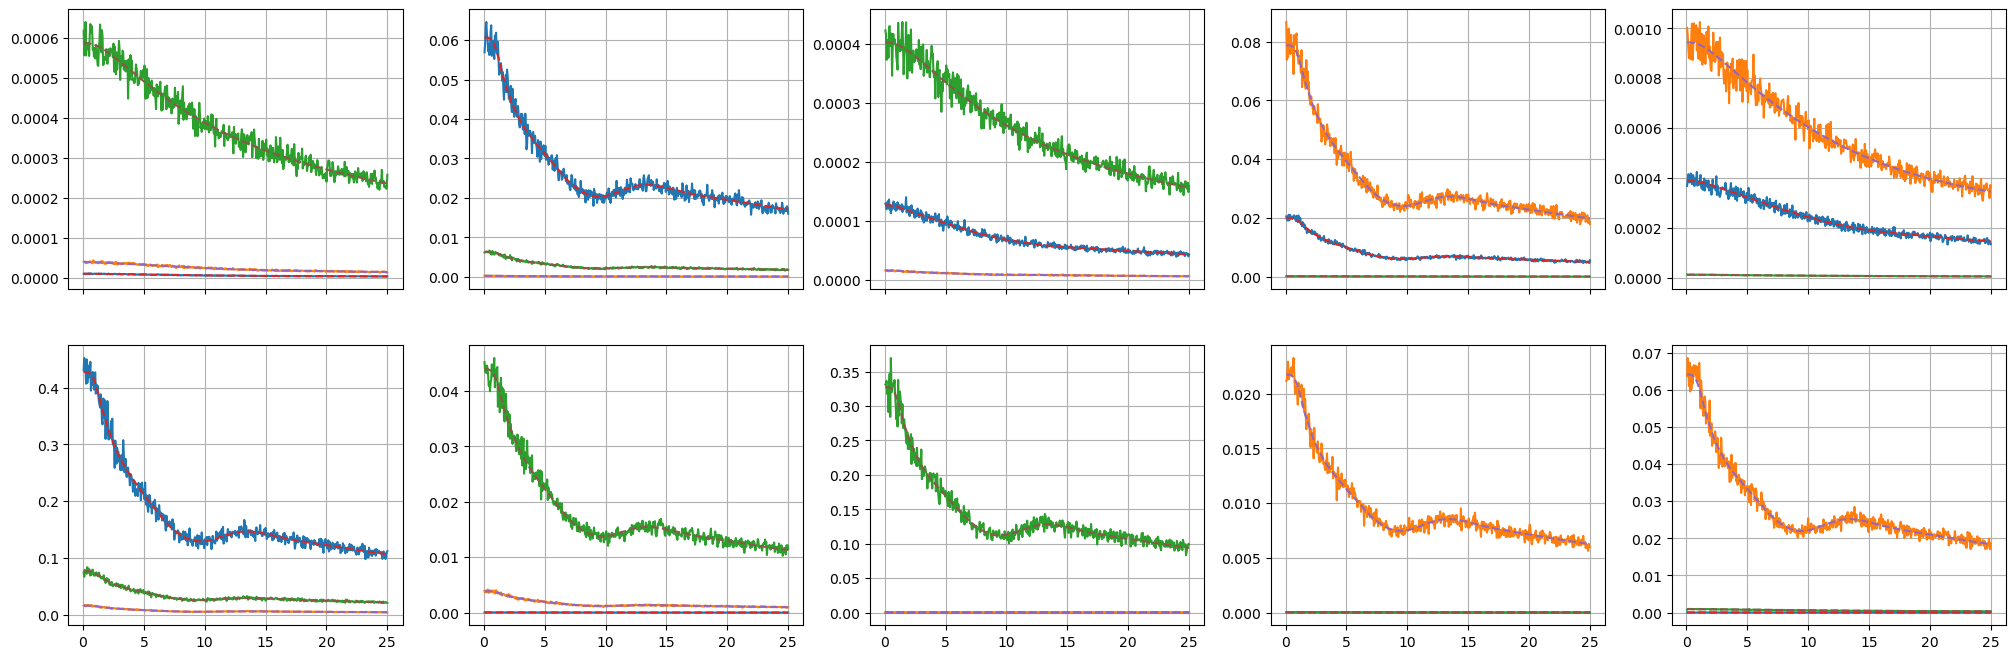

In [10]:
# # Check on the maximum
# np.max(np.abs(Xsensor_clean[j]))

ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize= (5 * ncols, 4 * nrows))
axs = axs.flatten()

for kk in range(nrows * ncols):
    axs[kk].plot(new_t, Xsensor[:,:,kk].T, label='Spline')
    axs[kk].plot(times, snap_measurements[:,:,kk].T, '--', label='FOM')
    axs[kk].grid()

Let us plot the locations of the sensors

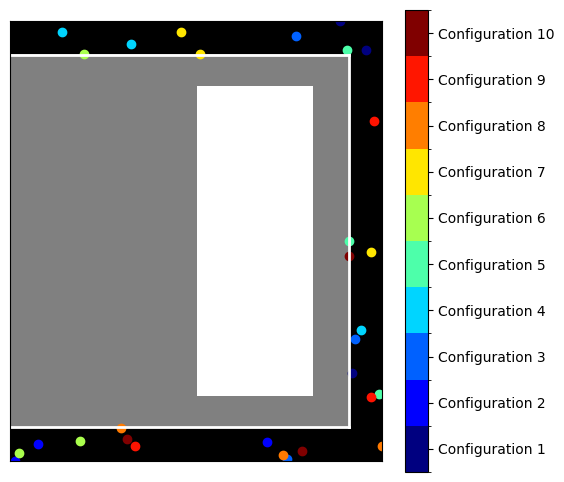

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming necessary imports and data are available
cmap = plt.cm.jet
colors = cmap(np.linspace(0, 1, n_configurations))
fig, axs = plt.subplots(figsize=(6, 6))

mesh = fun_spaces[measured_field].tabulate_dof_coordinates()

# Defining the rectangles for the blue zones
rect_core = patches.Rectangle((0, -2.26/2), 2.05, 2.26, linewidth=1, facecolor='gray')
rect_reflector_top = patches.Rectangle((0, 2.26/2), 2.25, 0.20, linewidth=1, facecolor='black')
rect_reflector_bot = patches.Rectangle((0, -2.26/2), 2.25, -0.20, linewidth=1, facecolor='black')
rect_reflector_lateral = patches.Rectangle((2.05, -2.26/2), 0.2, 2.26, linewidth=1, facecolor='black')
rect_blanket = patches.Rectangle((1.13, -1.88/2), 0.7, 1.88, linewidth=1, facecolor='white')

axs.add_patch(rect_core)
axs.add_patch(rect_reflector_top)
axs.add_patch(rect_reflector_bot)
axs.add_patch(rect_reflector_lateral)
axs.add_patch(rect_blanket)

# Setting the limits and aspect
axs.set_xlim(0, 2.25)
axs.set_ylim(-2.66/2, 2.66/2)
axs.set_aspect('equal')

# Scatter plot for sensor locations
for kk in range(n_configurations):
    axs.scatter(mesh[idx_sensor_locations[:, kk].flatten(), 0], mesh[idx_sensor_locations[:, kk].flatten(), 1], color=colors[kk])

axs.set_xticks([])
axs.set_yticks([])

# Create a discrete colormap and normalization
bounds = np.linspace(1, n_configurations+1, n_configurations+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the discrete colorbar to the plot
midpoints = (bounds[:-1] + bounds[1:]) / 2
cbar = plt.colorbar(sm, ax=axs, ticks=np.arange(n_configurations + 1))
cbar.ax.set_yticks(midpoints)
cbar.ax.set_yticklabels([f'Configuration {i}' for i in np.hstack([np.array([1]), np.arange(2, n_configurations + 1, 1, dtype=int)])])

# Plot lines
axs.plot([-0.25, 2.05], [2.25/2]*2, c='white', linewidth=2)
axs.plot([-0.25, 2.05], [-2.25/2]*2, c='white', linewidth=2)
axs.plot([2.05]*2, [2.25/2, -2.25/2], c='white', linewidth=2)

# Save the figure
# fig.savefig(path_svd+'sensors.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us store the measurements

In [14]:
measurements = dict()
measurements['mesh'] = mesh
measurements['location'] = idx_sensor_locations
measurements['point_spread'] = point_spread
measurements['noise'] = noise_value

measurements['measured_field'] = measured_field

measurements['noisy_output'] = Xsensor

if incore:
    pickle.dump(measurements, open(path_svd+'measurements_incore.data', 'wb'))
else:
    pickle.dump(measurements, open(path_svd+'measurements_'+str(num_sensors)+'.data', 'wb'))